In [1]:
if(!require(install.load)) {install.packages("install.load");
library(install.load)}
install_load("plyr", "dplyr", "tidyr", "readr", "car",
             "ggplot2", "cowplot",
             "MCMCglmm", "evolqg",
             "devtools", "mvoutlier")

Loading required package: install.load

Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand

Loading required package: coda
Loading required package: ape
Loading required package: sgeostat
sROC 0.1-2 loaded


# Outline

Introduce the goals and approaches we will use -
Start with mapping in an F2 (pros and cons - loads of LD but no population structure)
Look at the structure of data sets and distribution of traits.
Use F2 data to do basic analysis. Can start with ANOVA model (use marker 16 and trait 2a since that is a simulated QTL) and look at output.  We can then run that as a regression model.  Finally, we can create dominance index variable to separate additive from dominance effect.  I did not simulate any dominance effects, so maybe I need to go back and make the locus have both effects! (since it would be nice to see how the separation of a and d provides information - I’ll add this to the to-do list)
 
We can then talk about using this model for an iterative analysis that walks across markers.  Discuss use of LPR or LOD as a measure of significance.  Look at how the single locus measure of significance is not a definitive test because LD causes an autocorrelation in effects across sites.
 
Run this iterative model for trait 3a, which has two QTL.  Look at the position of peaks. (maybe I should also simulate a trait, like 3b that has two QTL but of opposite sign so we can also see interference - I’ll also add this to the to-do list).
 
Discuss using marker co-factors to identify locations of QTL.
 
Next we can discuss significance testing - permutation of either G or P to generate distribution under null model.  Run the model for trait 1 - should be biased if the model assumes normality (since it is a highly skewed trait).  Can use the empirical distribution to adjust threshold. 
 
We can also use this model to simulate a true positive and look at power.  Simulate an effect size of 1%, 2%, 5% and look at proportion that beat the significance threshold.
 
Introduce the F3 and the importance of population stratification.
 
We could start by running the null model for the simulated markers and look at the inflation of false positive?  Then run a permutation with total randomization to show that it would appear unbiased if we ignored population structure.  We can then introduce the mixed model analysis to account for population structure (perhaps Alastair can also comment on this in relation to a population with a complex pedigree). Then re-run the analysis of the null model?
 
I simulated one pleiotropic QTL in the F3 - so we can analyze the effect on traits 2a and 3a and we should see the same QTL appear - we can discuss this in relation to pleiotropy.
 
Lab session later in the week:
Genome prediction - fitting a model with all markers to predict phenotypes and how this can be used to estimate a genomic breeding value (basically a sort of BLUE for an individual based on their markers while estimating their BLUP from the random effects)
 
Multivariate model - go back to pleiotropic QTL and discuss how we could estimate the vector of effect while fitting G?

# Introduction to QTL mapping

We'll begin this tutorial with a simple unstructured F2 population. This is a population resulting from one generation of random mating of a hibrid population formed by breeding two pure strains.

![](f2pop.png)

Let's first read the data we need and make some plots to see if our traits were measured and imported correctly.

# Reading and plotting data

In [2]:
f2_data = read_csv("./F2 geno pheno with QTL effect.csv")
f2_data

Parsed with column specification:
cols(
  .default = col_integer(),
  Sex = col_character(),
  trait1 = col_double(),
  trait2 = col_double(),
  trait3 = col_double(),
  Trait2a = col_double(),
  Trait3a = col_double()
)
See spec(...) for full column specifications.


ID,Sex,Sire,Dam,LSB,LSW,trait1,trait2,trait3,G1,⋯,G24,G25,G26,G27,G28,G29,G30,G31,Trait2a,Trait3a
55,M,0,13,9,9,2.7840078,84.136,30.702,1,⋯,0,0,0,0,0,0,0,0,84.13600,30.70200
56,M,0,13,9,9,2.9961462,91.376,37.442,-1,⋯,0,0,0,-1,-1,-1,0,1,89.29098,34.34656
57,M,0,13,9,9,4.4964274,97.516,44.382,0,⋯,0,1,1,1,0,0,0,0,97.51600,44.38200
58,F,0,13,9,9,4.1677393,86.236,27.362,0,⋯,-1,-1,-1,-1,-1,-1,-1,-1,84.15098,25.81428
59,M,0,13,9,9,8.3322971,90.316,47.872,-1,⋯,-1,-1,-1,-1,-1,-1,0,0,88.23098,44.77656
60,F,0,13,9,9,6.0586791,74.856,31.912,1,⋯,0,0,0,0,0,0,0,0,74.85600,31.91200
61,F,0,13,9,9,5.2987302,91.926,34.582,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,89.84098,31.48656
62,M,0,13,9,9,5.0645314,95.696,45.092,1,⋯,0,0,0,0,-1,-1,-1,-1,95.69600,45.09200
63,F,0,13,9,9,4.7603125,86.126,25.982,0,⋯,0,0,0,0,0,0,0,0,86.12600,25.98200
64,F,0,13,11,11,1.0888584,91.126,32.162,1,⋯,0,0,0,0,0,0,0,0,91.12600,32.16200


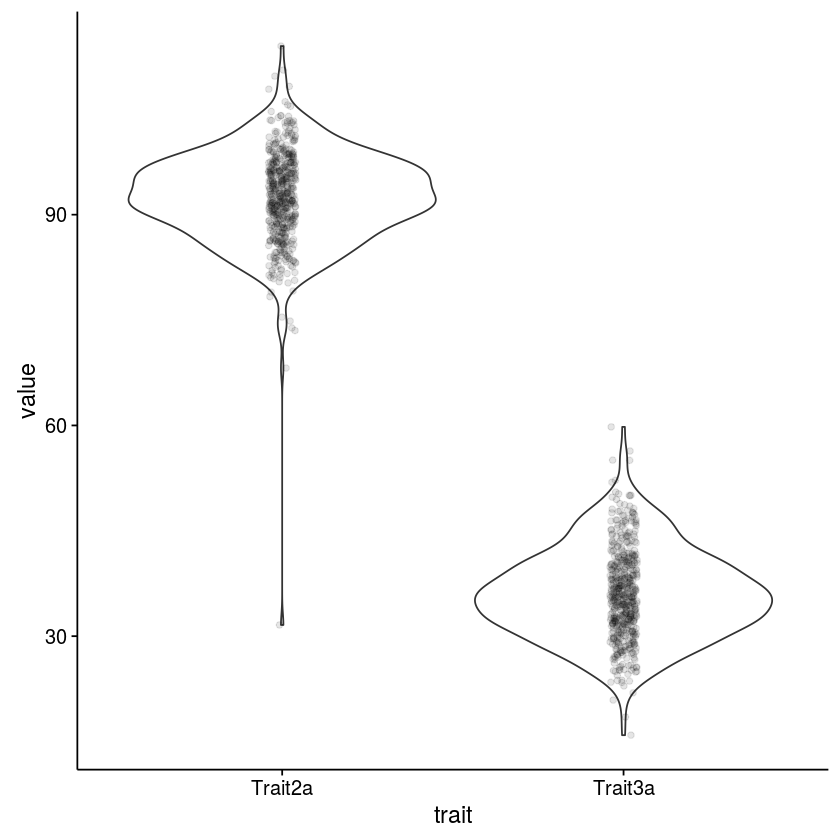

In [3]:
f2_data %>% 
    gather(trait, value, Trait2a:Trait3a) %>%
    ggplot(aes(trait, value)) + geom_violin() + geom_jitter(width = 0.1, alpha = 0.1)

# Simple single marker models

## Anova model

The most simple way of mapping a quantitative trait locus is using an Anova. We divide a particular marker position into 3 classes (homozigotes and the heterozigotes) and look for diferences among the classes. Later we'll see how to dissect this further. This model is comparing the different genotypes states of the G16 marker with respect to the Trait2a phenotype. We are also controling for differences in Sex, litter size at birth (LSB) and litter size at weaning (LSW).

![](f2popQtl.png)

The lm() function in R can be used for this test.

In [4]:
anova_fit_f2_marker_16 = lm(Trait2a ~ Sex + LSB + LSW + as.factor(G16), data = f2_data)
Anova(anova_fit_f2_marker_16)

,Sum Sq,Df,F value,Pr(>F)
Sex,1404.73117,1,36.4635275,3.064203e-09
LSB,20.72801,1,0.5380504,4.635905e-01
LSW,126.60330,1,3.2863248,7.046730e-02
as.factor(G16),1828.64853,2,23.7337140,1.442373e-10
Residuals,18992.47044,493,NA,NA


## Regression models

Another way of doing this is using a regression model, in which we code the different genotypes numericaly (-1 for one homozygote, 0 for the heterozygotes, and +1 for the other homozygote). The coeficient associated with this encoding is related to the additive effect of the marker. 

In [5]:
reg_fit_f2_marker_16_A = lm(Trait2a ~ Sex + LSB + LSW + G16, data = f2_data)
summary(reg_fit_f2_marker_16_A)


Call:
lm(formula = Trait2a ~ Sex + LSB + LSW + G16, data = f2_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-63.087  -3.458   0.326   3.887  22.483 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  87.7976     1.6781  52.321  < 2e-16 ***
SexM          3.4304     0.5626   6.098 2.17e-09 ***
LSB          -0.1291     0.1890  -0.683   0.4948    
LSW           0.3948     0.2228   1.772   0.0771 .  
G16           2.7424     0.4049   6.773 3.59e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.21 on 494 degrees of freedom
  (6 observations deleted due to missingness)
Multiple R-squared:  0.1471,	Adjusted R-squared:  0.1402 
F-statistic:  21.3 on 4 and 494 DF,  p-value: 3.169e-16


We can also use a coding of 1 for the heterozygotes and 0 for the homozygotes to extract a coeficient related to the dominance effect of the marker.

In [6]:
f2_data$G16_D = ifelse(f2_data$G16, 0, 1)
reg_fit_f2_marker_16_AD = lm(Trait2a ~ Sex + LSB + LSW + G16 + G16_D, data = f2_data)
summary(reg_fit_f2_marker_16_AD)


Call:
lm(formula = Trait2a ~ Sex + LSB + LSW + G16 + G16_D, data = f2_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-63.397  -3.424   0.465   3.742  22.142 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  87.4519     1.7001  51.438  < 2e-16 ***
SexM          3.3987     0.5628   6.039 3.06e-09 ***
LSB          -0.1387     0.1890  -0.734   0.4636    
LSW           0.4040     0.2228   1.813   0.0705 .  
G16           2.7634     0.4050   6.823 2.62e-11 ***
G16_D         0.6923     0.5582   1.240   0.2154    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.207 on 493 degrees of freedom
  (6 observations deleted due to missingness)
Multiple R-squared:  0.1498,	Adjusted R-squared:  0.1412 
F-statistic: 17.37 on 5 and 493 DF,  p-value: 7.503e-16


# Mapping loci

If we have a set of markers we can run a series of single markers models along the chromossome to locate the position of the QTL in that cromossome. Let's create dominance collumns and run the regression models for each marker

In [7]:
n_markers = 31
marker_fits = list()
for(i in seq(n_markers)){
    current_marker = paste0('G', i)
    f2_data[[paste0(current_marker, '_D')]] = ifelse(f2_data[[current_marker]], 0, 1)
    model_formula = paste0("Trait2a ~ Sex + LSB + LSW + ", current_marker, "+", current_marker, "_D")
    marker_fits[[i]] = lm(as.formula(model_formula), data = f2_data)
}

Let's look at one of the model fits to see if everything is ok

In [8]:
summary(marker_fits[[3]])


Call:
lm(formula = as.formula(model_formula), data = f2_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-62.931  -3.663   0.441   4.088  23.045 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  88.0207     1.7837  49.348  < 2e-16 ***
SexM          3.4777     0.5852   5.942 5.32e-09 ***
LSB          -0.1831     0.1965  -0.932   0.3518    
LSW           0.4633     0.2317   2.000   0.0460 *  
G3            0.9892     0.4164   2.376   0.0179 *  
G3_D         -0.6157     0.5789  -1.064   0.2880    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.455 on 493 degrees of freedom
  (6 observations deleted due to missingness)
Multiple R-squared:  0.08042,	Adjusted R-squared:  0.0711 
F-statistic: 8.623 on 5 and 493 DF,  p-value: 7.578e-08


We can use this set of fits to see how the log significance changes along the cromossome

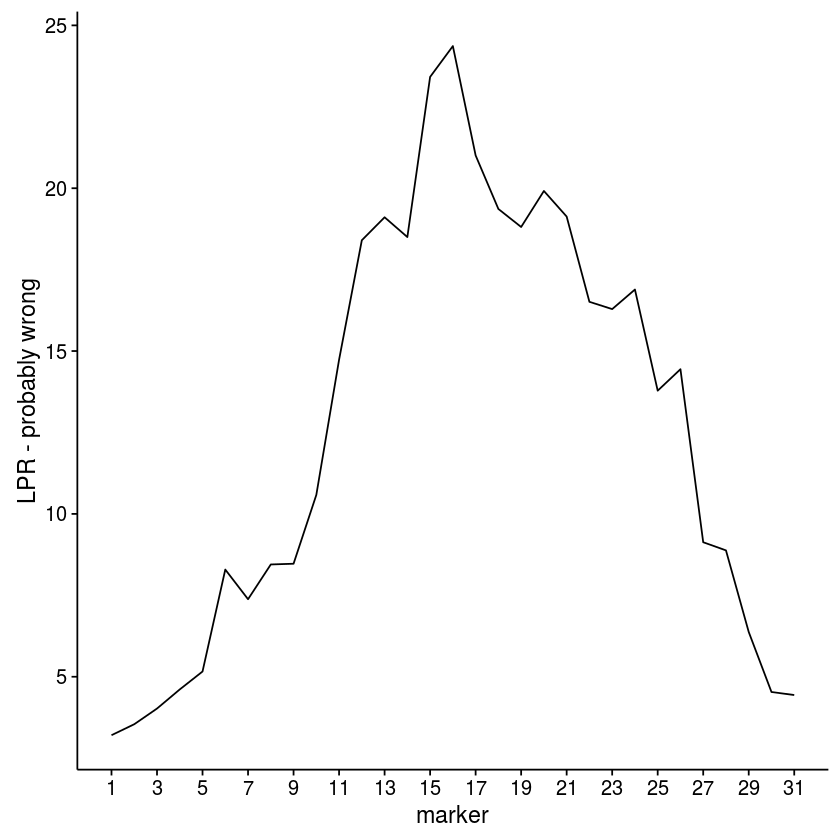

In [9]:
ldply(marker_fits, function(x) summary(x)$coefficients[5, 'Pr(>|t|)']) %>%
    ggplot(aes(1:n_markers, -log(V1))) + geom_line() + labs(x = "marker", y = "LPR - probably wrong") +
        scale_x_continuous(breaks = seq(1, n_markers, by = 2))

## More than one effect

In [10]:
marker_fits_Trait3a = list()
for(i in seq(n_markers)){
    current_marker = paste0('G', i)
    model_formula = paste0("Trait3a ~ Sex + LSB + LSW + ", current_marker, "+", current_marker, "_D")
    marker_fits_Trait3a[[i]] = lm(as.formula(model_formula), data = f2_data)
}

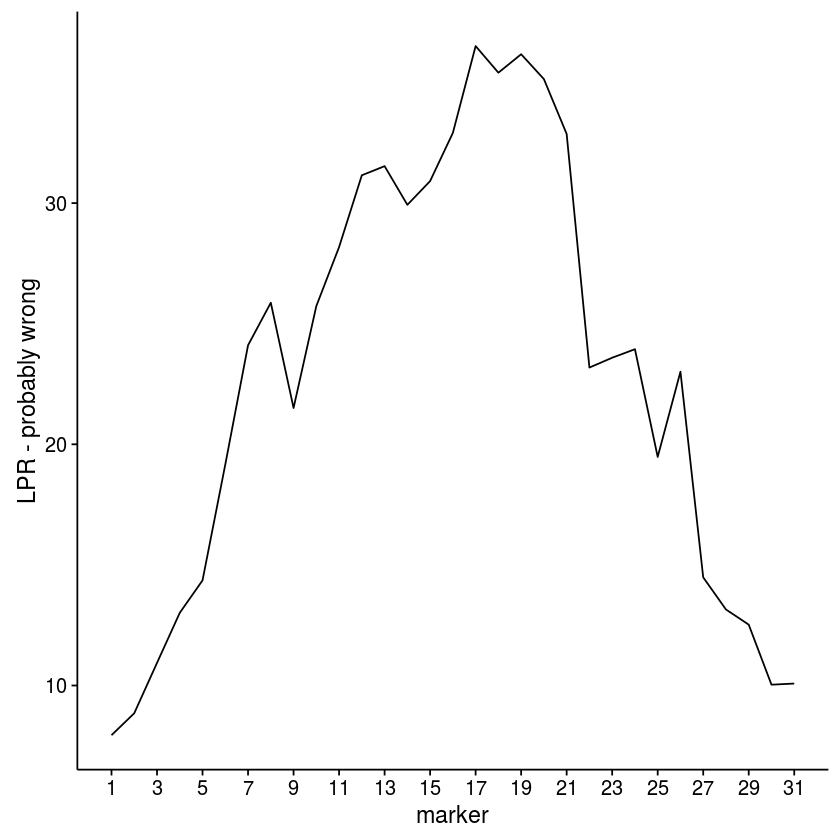

In [11]:
ldply(marker_fits_Trait3a, function(x) summary(x)$coefficients[5, 'Pr(>|t|)']) %>%
    ggplot(aes(1:n_markers, -log(V1))) + geom_line() + labs(x = "marker", y = "LPR - probably wrong") +
        scale_x_continuous(breaks = seq(1, n_markers, by = 2))

## Including more than one marker in a model

We can take LD into account in the mapping by including flanking markers. This provides more localised estimates of the QTLs.

In [12]:
fit_f2_m13         = lm(Trait2a ~ Sex + LSB + LSW + G13 + G13_D                            , data = f2_data)
fit_f2_m13_fl11_15 = lm(Trait2a ~ Sex + LSB + LSW + G13 + G13_D + G11 + G11_D + G15 + G15_D, data = f2_data)
summary(fit_f2_m13)$coefficients
summary(fit_f2_m13_fl11_15)$coefficients

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),87.6413530,1.7324709,50.5874906,2.671517e-197
SexM,3.4628299,0.5686496,6.0895667,2.280061e-09
LSB,-0.1629151,0.1910395,-0.8527825,3.941940e-01
LSW,0.4185185,0.2255232,1.8557674,6.408327e-02
G13,2.4051075,0.4040818,5.9520309,5.031517e-09
G13_D,0.4060069,0.5645838,0.7191259,4.724040e-01


,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),87.72057335,1.7209586,50.97192424,8.588947e-198
SexM,3.41434735,0.5638730,6.05517087,2.797913e-09
LSB,-0.16171773,0.1902646,-0.84996249,3.957619e-01
LSW,0.41092536,0.2241499,1.83326160,6.737138e-02
G13,-0.07477335,1.3187892,-0.05669849,9.548085e-01
G13_D,-0.07441339,1.3300531,-0.05594768,9.554063e-01
G11,-0.14885092,0.9305673,-0.15995717,8.729809e-01
G11_D,-1.40745596,1.0503281,-1.34001555,1.808626e-01
G15,2.81680603,1.0017740,2.81181795,5.124188e-03
G15_D,1.94408410,1.0136817,1.91784473,5.571283e-02


Now let's redo all the individual markers, but including 2 flanking markers in the models. The markers at the edge of the chromossome only get one flanking marker.

In [13]:
n_markers = 31
interval = 6 # Play around with this value. 
fl_marker_fits = list()
for(i in seq(n_markers)){
    current_marker = paste0('G', i)
    f2_data[[paste0(current_marker, '_D')]] = ifelse(f2_data[[current_marker]], 0, 1)
    model_formula = paste0("Trait3a ~ Sex + LSB + LSW + ", current_marker, "+", current_marker, "_D")
    if((i - interval) >= 1)
        model_formula = paste0(model_formula, "+ G", paste0(i - interval), "+ G", paste0(i - interval), "_D")
    if((i + interval) <= n_markers)
        model_formula = paste0(model_formula, "+ G", paste0(i + interval), "+ G", paste0(i + interval), "_D")
    fl_marker_fits[[i]] = lm(as.formula(model_formula), data = f2_data)
}

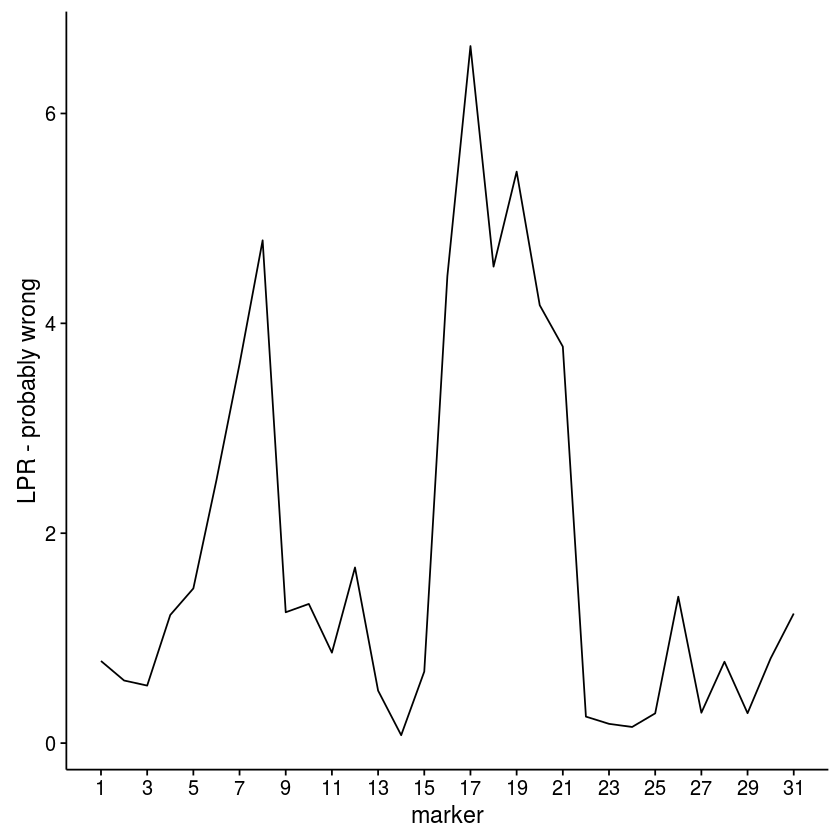

In [14]:
ldply(fl_marker_fits, function(x) summary(x)$coefficients[5, 'Pr(>|t|)']) %>%
    ggplot(aes(1:n_markers, -log(V1))) + geom_line() + labs(x = "marker", y = "LPR - probably wrong") +
    scale_x_continuous(breaks = seq(1, n_markers, by = 2))

# Significance testing problems

Let's run a null model, with no QTLs, and see how many false postives we get. The expectation is the significance treashold we choose (5% maybe?).

In [16]:
marker_fits_trait1 = list()
for(i in seq(n_markers)){
    current_marker = paste0('G', i)
    model_formula = paste0("trait1 ~ Sex + LSB + LSW + ", current_marker, "+", current_marker, "_D")
    marker_fits_trait1[[i]] = lm(as.formula(model_formula), data = f2_data)
}

In [22]:
laply(marker_fits_trait1, function(x) summary(x)$coefficients[5, 'Pr(>|t|)'])

[1] 0.8330074 0.7383013 0.9170131 0.8676937 0.7200043 0.9768537 0.6949799
 [8] 0.6795887 0.8318420 0.5723259 0.3242770 0.3352229 0.2418181 0.4139989
[15] 0.5473536 0.4622926 0.4450944 0.6415329 0.5855122 0.9632113 0.9513570
[22] 0.3436546 0.5906791 0.5939455 0.5693685 0.6592654 0.9015134 0.8050986
[29] 0.7602993 0.9010220 0.9937514